In [1]:
from lib import vrep
import sys, time
from src import robot as rb
from src.utils import vrep2array

In [ ]:
class Walker():
    """
    A class used to implement methods that allow a robot to walk, based on different behaviors.

    ...

    Attributes
    ----------
    robot : obj
        the robot object
    pose : list
        list to store the robot's pose during his movement
    orientation : list
        list to store the robot's orientation during his movement

    Methods
    -------
    find_wall()
        Function that aims to find a wall in the front of the robot.
    turn_left()
        Function that aims to make the robot turn left.
    follow_wall()
        Function that aims to make the robot follow the wall that stays at his left side.
    """
    def __init__(self, robot):
        """
            Instanciate the object
        """
        self.robot = robot
        self.pose = []
        self.orientation = []
    
    def find_wall(self):
        """
            Function that aims to find a wall in the front of the robot.
        """
        #  read the sonars
        sensors = self.robot.read_ultrassonic_sensors()
        
        # set the initial velocity
        self.robot.set_left_velocity(3)
        self.robot.set_right_velocity(3)
        
        # loop to make the robot walk until he finds a wall
        while sensors[3] > 0.8 and sensors[4] > 0.8:
            self.pose.append(self.robot.get_current_position())
            self.orientation.append(self.robot.get_current_orientation())
            sensors = self.robot.read_ultrassonic_sensors()
        
        # stop the robot and return
        self.robot.stop()
        
        return
    
    def turn_left(self):
        """
            Function that aims to make the robot turn left.
        """
        # read the sonar sensors
        sensors = self.robot.read_ultrassonic_sensors()
        
        # start the motors velocity
        self.robot.set_left_velocity(1.5)
        self.robot.set_right_velocity(0)
        
        while (sensors[0] > 0.5 and sensors[15] > 0.5) or (sensors[0] - sensors[15] > 0.1) or (sensors[15] - sensors[0] > 0.1):
            self.pose.append(self.robot.get_current_position())
            self.orientation.append(self.robot.get_current_orientation())
            sensors = self.robot.read_ultrassonic_sensors()
        
        self.robot.stop()
        
        return

    def follow_wall(self):
        """
            Function that aims to make the robot follow the wall that stays at his left side.
        """
        sensors = self.robot.read_ultrassonic_sensors()

        if sensors[3] < 0.6 or sensors[4] < 0.6 or sensors[5] < 0.6 or sensors[6] < 0.6:
            self.robot.set_right_velocity(0)
            self.robot.set_left_velocity(1.5)
        elif sensors[0] < 0.37 or sensors[1] < 0.37 or sensors[2] < 0.37:
            self.robot.set_right_velocity(0)
            self.robot.set_left_velocity(1.5)
        elif sensors[0] > 0.55 or sensors[1] > 0.55:
            self.robot.set_right_velocity(1.5)
            self.robot.set_left_velocity(0)
        else:
            self.robot.set_right_velocity(1.5)
            self.robot.set_left_velocity(1.5)

        self.pose.append(self.robot.get_current_position())
        self.orientation.append(self.robot.get_current_orientation())
        
        return

DAQUI PRA BAIXO É TESTE

In [ ]:
def state_machine(behavior="follow_wall"):
    # first we create the robot and the walker object
    robot = rb.Robot()
    walker_behavior = Walker(robot)
    
    # first state is to find a wall
    if behavior == "follow_wall":
        # first we find a wall
        walker_behavior.find_wall()
        
        # then we align to the wall
        walker_behavior.turn_left()
        
        # now we follow the wall
        while True:
            # TODO: call other important functions
            # call the function that keeps following the left wall
            walker_behavior.follow_wall()
    else:
        raise Exception("Not implemented!")
        

In [3]:
robot = rb.Robot()

Connected to remoteApi server.
 Pioneer_p3dx_ultrasonicSensor1 connected.
 Pioneer_p3dx_ultrasonicSensor2 connected.
 Pioneer_p3dx_ultrasonicSensor3 connected.
 Pioneer_p3dx_ultrasonicSensor4 connected.
 Pioneer_p3dx_ultrasonicSensor5 connected.
 Pioneer_p3dx_ultrasonicSensor6 connected.
 Pioneer_p3dx_ultrasonicSensor7 connected.
 Pioneer_p3dx_ultrasonicSensor8 connected.
 Pioneer_p3dx_ultrasonicSensor9 connected.
 Pioneer_p3dx_ultrasonicSensor10 connected.
 Pioneer_p3dx_ultrasonicSensor11 connected.
 Pioneer_p3dx_ultrasonicSensor12 connected.
 Pioneer_p3dx_ultrasonicSensor13 connected.
 Pioneer_p3dx_ultrasonicSensor14 connected.
 Pioneer_p3dx_ultrasonicSensor15 connected.
 Pioneer_p3dx_ultrasonicSensor16 connected.
 Vision sensor connected.
 Laser connected.
 Left motor connected.
 Right motor connected.
 Robot connected.


In [4]:
image = robot.read_vision_sensor()

In [5]:
image

([256, 256],
 [-56,
  -61,
  -70,
  -56,
  -62,
  -72,
  -56,
  -62,
  -73,
  -57,
  -62,
  -73,
  -57,
  -62,
  -72,
  -57,
  -62,
  -71,
  -57,
  -62,
  -71,
  -57,
  -61,
  -71,
  -57,
  -61,
  -72,
  -57,
  -61,
  -73,
  -57,
  -62,
  -74,
  -57,
  -61,
  -72,
  -57,
  -61,
  -71,
  -57,
  -61,
  -72,
  -57,
  -61,
  -72,
  -56,
  -61,
  -71,
  -56,
  -61,
  -71,
  -55,
  -62,
  -69,
  -55,
  -62,
  -67,
  -57,
  -63,
  -68,
  -59,
  -63,
  -70,
  -59,
  -63,
  -74,
  -59,
  -63,
  -78,
  -59,
  -63,
  -78,
  -59,
  -64,
  -77,
  -59,
  -64,
  -75,
  -59,
  -65,
  -73,
  -58,
  -64,
  -74,
  -58,
  -64,
  -76,
  -58,
  -63,
  -76,
  -58,
  -63,
  -74,
  -58,
  -64,
  -72,
  -59,
  -64,
  -70,
  -59,
  -65,
  -69,
  -60,
  -64,
  -71,
  -61,
  -63,
  -71,
  -60,
  -63,
  -68,
  -59,
  -63,
  -67,
  -59,
  -64,
  -71,
  -59,
  -65,
  -75,
  -60,
  -66,
  -76,
  -61,
  -67,
  -76,
  -61,
  -66,
  -77,
  -61,
  -65,
  -79,
  -60,
  -67,
  -77,
  -59,
  -68,
  -76,
  -57,
  -65,
  -73,


In [14]:
image_converted = vrep2array(image[1],image[0])

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

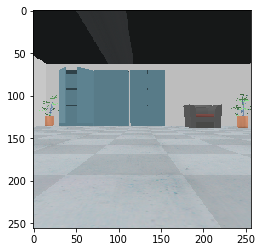

In [16]:
plt.imshow(image_converted)